In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.font_manager as fm
from textwrap import wrap

from statsmodels.stats.multitest import multipletests

from itertools import combinations, chain
import upsetplot

import json

import helper

import config
config.config_visuals()

# Load rMATS outputs

In [2]:
with open("experiments.json", "r") as f:
    exp = json.load(f)

    experiments = exp["experiments"]
    experiment_ids = exp["experiment_ids"]
    display_names = exp["display_names"]
    display_groups = exp["display_groups"]
    contexts = exp["contexts"]

In [3]:
rpl22_oe_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_oe.h5", key="rmats")
rpl22l1_oe_rmats = pd.read_hdf(
    "../data/processed/rmats_merge/rpl22l1_oe.h5", key="rmats"
)
rpl22l1_kd1_rmats = pd.read_hdf(
    "../data/processed/rmats_merge/rpl22l1_kd1.h5", key="rmats"
)
rpl22l1_kd2_rmats = pd.read_hdf(
    "../data/processed/rmats_merge/rpl22l1_kd2.h5", key="rmats"
)
rpl22_a_ko1_rmats = pd.read_hdf(
    "../data/processed/rmats_merge/rpl22_a_ko1.h5", key="rmats"
)
rpl22_a_ko2_rmats = pd.read_hdf(
    "../data/processed/rmats_merge/rpl22_a_ko2.h5", key="rmats"
)
rpl22_b_ko1_rmats = pd.read_hdf(
    "../data/processed/rmats_merge/rpl22_b_ko1.h5", key="rmats"
)
rpl22_b_ko2_rmats = pd.read_hdf(
    "../data/processed/rmats_merge/rpl22_b_ko2.h5", key="rmats"
)

rpl22_oe_rmats = rpl22_oe_rmats.rename({"PValue": "pval", "FDR": "qval"}, axis=1)
rpl22l1_oe_rmats = rpl22l1_oe_rmats.rename({"PValue": "pval", "FDR": "qval"}, axis=1)
rpl22l1_kd1_rmats = rpl22l1_kd1_rmats.rename({"PValue": "pval", "FDR": "qval"}, axis=1)
rpl22l1_kd2_rmats = rpl22l1_kd2_rmats.rename({"PValue": "pval", "FDR": "qval"}, axis=1)
rpl22_a_ko1_rmats = rpl22_a_ko1_rmats.rename({"PValue": "pval", "FDR": "qval"}, axis=1)
rpl22_a_ko2_rmats = rpl22_a_ko2_rmats.rename({"PValue": "pval", "FDR": "qval"}, axis=1)
rpl22_b_ko1_rmats = rpl22_b_ko1_rmats.rename({"PValue": "pval", "FDR": "qval"}, axis=1)
rpl22_b_ko2_rmats = rpl22_b_ko2_rmats.rename({"PValue": "pval", "FDR": "qval"}, axis=1)

splice_types = ["A3SS", "A5SS", "MXE", "RI", "SE"]

# Differential splicing

In [ ]:
axes = helper.all_bars(
    "MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436",
    "splicing",
)

for ax in axes:
    ax.set_ylim(0, 1.05)

axes[0].set_yticks([0, 0.25, 0.5, 0.75, 1.0])
axes[0].set_ylabel("MDM4 exon 6 PSI")

plt.savefig("../plots/MDM4_6_splicing.pdf", bbox_inches="tight", transparent=True)

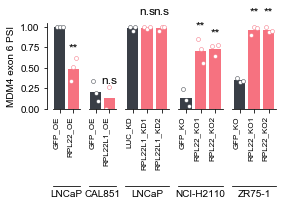

In [172]:
axes = helper.all_bars(
    "MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436",
    "splicing",
)

for ax in axes:
    ax.set_ylim(0, 1.05)

axes[0].set_yticks([0, 0.25, 0.5, 0.75, 1.0])
axes[0].set_ylabel("MDM4 exon 6 PSI")

plt.savefig("../plots/MDM4_6_splicing.pdf", bbox_inches="tight", transparent=True)

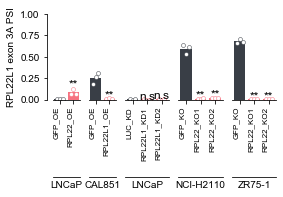

In [173]:
axes = helper.all_bars(
    "RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176",
    "splicing",
)

for ax in axes:
    ax.set_ylim(0, 1)
axes[0].set_yticks([0, 0.25, 0.5, 0.75, 1.0])
axes[0].set_ylabel("RPL22L1 exon 3A PSI")

plt.savefig("../plots/RPL22L1_3A_splicing.pdf", bbox_inches="tight", transparent=True)

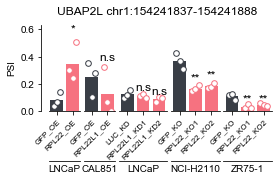

In [7]:
axes = helper.all_bars(
    "UBAP2L_ENSG00000143569_154241837_154241888_154241232_154241430_154242675_154243040",
    "splicing",
)

plt.suptitle("UBAP2L chr1:154241837-154241888")
plt.savefig("../plots/UBAP2L_splicing.pdf", bbox_inches="tight", transparent=True)

# Splicing types

In [141]:
inclusion_events = pd.DataFrame(index=splice_types)
exclusion_events = pd.DataFrame(index=splice_types)

for experiment_idx, experiment in enumerate(
    [
        rpl22_oe_rmats,
        rpl22l1_oe_rmats,
        rpl22l1_kd1_rmats,
        rpl22l1_kd1_rmats,
        rpl22_a_ko1_rmats,
        rpl22_a_ko2_rmats,
        rpl22_b_ko1_rmats,
        rpl22_b_ko2_rmats,
    ]
):

    experiment_name = display_names[experiment_idx]

    significants = experiment.copy(deep=True)[experiment["qval"] < 0.01]

    significants["treatment_increase"] = (
        significants["treatment_median"] > significants["control_median"]
    )

    significants["treatment_increase"] = significants["treatment_increase"].replace(
        {True: "Inclusion", False: "Exclusion"}
    )
    significants = significants.groupby("splice_type")[
        "treatment_increase"
    ].value_counts()
    significants = significants.unstack()

    inclusion_events[experiment_name] = significants["Inclusion"]
    exclusion_events[experiment_name] = significants["Exclusion"]

inclusion_events = inclusion_events.fillna(0)
exclusion_events = exclusion_events.fillna(0)

inclusion_events = inclusion_events[inclusion_events.columns[::-1]]
exclusion_events = exclusion_events[exclusion_events.columns[::-1]]

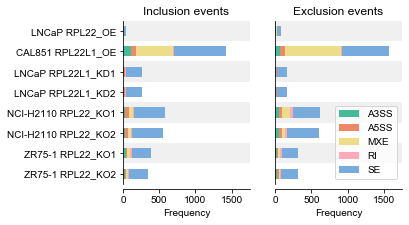

In [170]:
plt.figure(figsize=(5, 3))

splice_type_palette = mpl.colors.ListedColormap(
    ["#44bb99", "#ee8866", "#eedd88", "#ffaabb", "#77aadd"]
)

ax = plt.subplot(121)

for i in np.arange(0, 8, 2) + 0.5:
    ax.axhspan(i, i + 1, facecolor="lightgrey", alpha=0.333)

inclusion_events.T.plot.barh(
    stacked=True, ax=ax, cmap=splice_type_palette, legend=False
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks([0, 500, 1000, 1500])
ax.set_xlim(0, 1750)
ax.set_title("Inclusion events")
ax.set_xlabel("Frequency")

ax.spines["bottom"].set_position(("outward", 5))


ax = plt.subplot(122)

for i in np.arange(0, 8, 2) + 0.5:
    ax.axhspan(i, i + 1, facecolor="lightgrey", alpha=0.333)

exclusion_events.T.plot.barh(
    stacked=True, ax=ax, cmap=splice_type_palette,
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_yticks([])
ax.set_xticks([0, 500, 1000, 1500])
ax.set_xlim(0, 1750)
ax.set_title("Exclusion events")
ax.set_xlabel("Frequency")

ax.spines["bottom"].set_position(("outward", 5))

plt.savefig("../plots/splice_types_summary.pdf", bbox_inches="tight", transparent=True)

# Overlaps

In [22]:
def get_overlaps(
    diffs, names, cutoff=0.01, direction=None, entity="exon", filter_empty=True
):

    assert len(diffs) == len(names), "Length of diffs and names should match"

    n_diffs = len(diffs)
    all_subset_indices = list(
        chain(*[combinations(range(n_diffs), i) for i in range(1, n_diffs + 1)])
    )

    significants = []

    for diff in diffs:

        if direction == None:

            significant = diff.copy(deep=True)[diff["qval"] < cutoff]

        if direction == "pos":

            significant = diff.copy(deep=True)[diff["qval"] < cutoff]
            significant = significant[significant["median_foldchange"] >= 1]

        elif direction == "neg":

            significant = diff.copy(deep=True)[diff["qval"] < cutoff]
            significant = significant[significant["median_foldchange"] < 1]

        if entity == "gene":

            significant_entities = set(significant["gene_id"])

        elif entity == "exon":

            significant_entities = set(significant.index)

        significants.append(significant_entities)

    intersections = []
    intersection_names = []

    for subset_indices in all_subset_indices:

        select_significants = set.intersection(
            *[significants[i] for i in subset_indices]
        )

        if len(subset_indices) < n_diffs:

            select_insignificants = set.union(
                *[significants[i] for i in range(n_diffs) if i not in subset_indices]
            )

            select_significants = select_significants - select_insignificants

        select_names = [names[i] for i in subset_indices]

        intersections.append(select_significants)
        intersection_names.append(select_names)

    intersection_sizes = [len(x) for x in intersections]

    if filter_empty:

        n_subsets = len(intersections)

        empty = [len(x) == 0 for x in intersections]

        intersections = [intersections[i] for i in range(n_subsets) if not empty[i]]
        intersection_names = [
            intersection_names[i] for i in range(n_subsets) if not empty[i]
        ]
        intersection_sizes = [
            intersection_sizes[i] for i in range(n_subsets) if not empty[i]
        ]

    return intersections, intersection_names, intersection_sizes

# Intersections

In [32]:
rpl22_int_rmats = [
    rpl22_b_ko2_rmats,
    rpl22_b_ko1_rmats,
    rpl22_a_ko2_rmats,
    rpl22_a_ko1_rmats,
    rpl22_oe_rmats,
]

rpl22_int_display_names = [
    "ZR75-1 RPL22_KO2",
    "ZR75-1 RPL22_KO1",
    "NCI-H2110 RPL22_KO2",
    "NCI-H2110 RPL22_KO1",
    "LNCaP RPL22_OE",
]

rpl22_ko_ints, rpl22_ko_int_names, rpl22_ko_int_sizes = get_overlaps(
    rpl22_int_rmats, rpl22_int_display_names
)

In [33]:
rpl22_ko_pivot = upsetplot.from_memberships(rpl22_ko_int_names, rpl22_ko_int_sizes)

rpl22_ko_pivot = rpl22_ko_pivot.reorder_levels(rpl22_int_display_names)

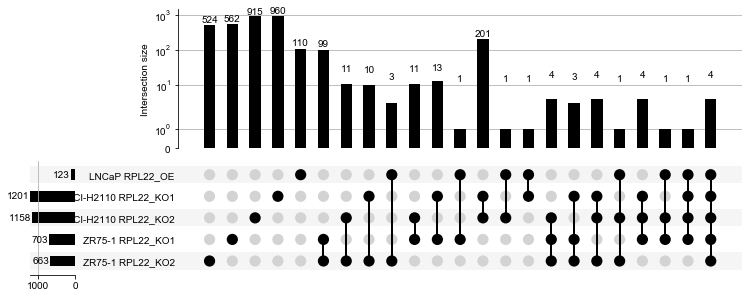

In [35]:
up = upsetplot.plot(rpl22_ko_pivot, sort_categories_by=None, show_counts=True)

up["intersections"].set_yscale("symlog")

plt.savefig(
    "../plots/RPL22_exon_intersections.pdf", transparent=True, bbox_inches="tight"
)

In [29]:
rpl22l1_int_rmats = [rpl22l1_kd2_rmats, rpl22l1_kd1_rmats, rpl22l1_oe_rmats]

rpl22l1_int_display_names = [
    "LNCaP RPL22L1_KD2",
    "LNCaP RPL22L1_KD1",
    "CAL851 RPL22L1_OE",
]

rpl22l1_ko_ints, rpl22l1_ko_int_names, rpl22l1_ko_int_sizes = get_overlaps(
    rpl22l1_int_rmats, rpl22l1_int_display_names
)

In [30]:
rpl22l1_ko_pivot = upsetplot.from_memberships(
    rpl22l1_ko_int_names, rpl22l1_ko_int_sizes
)

rpl22l1_ko_pivot = rpl22l1_ko_pivot.reorder_levels(rpl22l1_int_display_names)

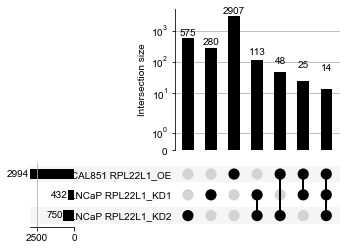

In [31]:
up = upsetplot.plot(rpl22l1_ko_pivot, sort_categories_by=None, show_counts=True)

up["intersections"].set_yscale("symlog")

plt.savefig(
    "../plots/RPL22L1_exon_intersections.pdf", transparent=True, bbox_inches="tight"
)